# Setup

In [ ]:
import warnings
import itertools
import os
import numpy as np
import seaborn as sns

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

from matplotlib import pyplot
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss

from math import sqrt
from random import random
from scipy import stats
from scipy.stats import skew

# https://facebook.github.io/prophet/docs/quick_start.html#python-api
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

# Import Dataset

## For Desktop

In [ ]:
# wanliu = pd.read_csv('/Users/isabellachittumuri/Desktop/Projects/STAT 715/PRSA_Data_Wanliu_20130301-20170228.csv')

## select columns
# wanliu = wanliu[["year", "month", "day", "hour", "PM2.5"]]

## into datetime
# wanliu['Datetime']=pd.to_datetime(wanliu[['year','month','day', 'hour']])

## keep only 2 columns
# wanliu = wanliu[["Datetime", "PM2.5"]]

## sort by date & time
# wanliu['Datetime'] = pd.to_datetime(wanliu['Datetime'])
# wanliu.sort_values(by=['Datetime'], axis=0, ascending=True, inplace=True)
# wanliu.reset_index(inplace=True, drop=True)

## display the first couple of rows
# wanliu.head()


## For Google Drive

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Data Preprocessing

In [ ]:
# let's only read one of the region's power consumptions, to keep this notebook concise
wanliu = pd.read_csv('/content/drive/MyDrive/715_project/PRSA_Data_Wanliu_20130301-20170228.csv', header=0, index_col=0, squeeze=True)

# select columns
wanliu = wanliu[["year", "month", "day", "hour", "PM2.5"]]

# into datetime
wanliu['Datetime']=pd.to_datetime(wanliu[['year','month','day', 'hour']])

# keep only 2 columns
wanliu = wanliu[["Datetime", "PM2.5"]]

# sort by date & time
wanliu['Datetime'] = pd.to_datetime(wanliu['Datetime'])
wanliu.sort_values(by=['Datetime'], axis=0, ascending=True, inplace=True)
wanliu.reset_index(inplace=True, drop=True)

# display the first couple of rows
wanliu.head()

,Datetime,PM2.5
0,2013-03-01 00:00:00,8.0
1,2013-03-01 01:00:00,9.0
2,2013-03-01 02:00:00,3.0
3,2013-03-01 03:00:00,11.0
4,2013-03-01 04:00:00,3.0


In [ ]:
wanliu.describe()

,PM2.5
count,34682.000000
mean,83.374716
std,81.905568
min,2.000000
25%,23.000000
50%,59.000000
75%,116.000000
max,957.000000


In [ ]:
print('Time period start: {}\nTime period end: {}'.format(wanliu["Datetime"].min(),wanliu["Datetime"].max()))

Time period start: 2013-03-01 00:00:00
Time period end: 2017-02-28 23:00:00


In [ ]:
wanliu.columns

Index(['Datetime', 'PM2.5'], dtype='object')

In [ ]:
wanliu.shape

(35064, 2)

In [ ]:
# check if there are duplicates
boolean = wanliu.duplicated().any() # False
boolean = wanliu.duplicated(subset=['Datetime','PM2.5']).any()
print(boolean)

False


False here - no duplicates row-wise 

In [ ]:
# convert the column (it's a string) to datetime type
datetime_series = pd.to_datetime(wanliu['Datetime'])

# create datetime index passing the datetime series
datetime_index = pd.DatetimeIndex(datetime_series.values)

df=wanliu.set_index(datetime_index)

# we don't need the column anymore
df.drop('Datetime',axis=1,inplace=True)

print(df.index)

DatetimeIndex(['2013-03-01 00:00:00', '2013-03-01 01:00:00', '2013-03-01 02:00:00', '2013-03-01 03:00:00', '2013-03-01 04:00:00', '2013-03-01 05:00:00', '2013-03-01 06:00:00', '2013-03-01 07:00:00', '2013-03-01 08:00:00', '2013-03-01 09:00:00',
               ...
               '2017-02-28 14:00:00', '2017-02-28 15:00:00', '2017-02-28 16:00:00', '2017-02-28 17:00:00', '2017-02-28 18:00:00', '2017-02-28 19:00:00', '2017-02-28 20:00:00', '2017-02-28 21:00:00', '2017-02-28 22:00:00', '2017-02-28 23:00:00'], dtype='datetime64[ns]', length=35064, freq=None)


## Fill Missing Values

In [ ]:
# Count total NaN in a DataFrame
print(" \nCount total NaN in a DataFrame : \n\n",
       df.isnull().sum().sum())

 
Count total NaN in a DataFrame : 

 382


In [ ]:
# uninterruped custom date range
date_range = pd.date_range(start=min(df.index), 
                           end=max(df.index), 
                           freq='H')

# this will append the previously missing datetimes, and create null values in our target variable
df = df.reindex(date_range)

# we fill in the blanks with values that lie on a linear curve between existing data points
df['PM2.5'].interpolate(method='linear', inplace=True)

# now we have a neatly continuous datetime index
print(f'The df.index.freq is now: {df.index.freq}, indicating that we no longer have missing instances')

The df.index.freq is now: <Hour>, indicating that we no longer have missing instances


In [ ]:
# check is any missing values left
print(" \nCount total NaN in a DataFrame : \n\n",
       df.isnull().sum().sum())

 
Count total NaN in a DataFrame : 

 0


# 24-Hour Average

In [ ]:
# daily
daily_avg = df.groupby(pd.Grouper(freq='D')).mean()

daily_avg.head()

,PM2.5
2013-03-01,8.000000
2013-03-02,29.083333
2013-03-03,80.125000
2013-03-04,22.875000
2013-03-05,134.041667


## Create Df Copy

In [ ]:
daily_avg_copy =  daily_avg
daily_avg_copy.head()

,PM2.5
2013-03-01,8.000000
2013-03-02,29.083333
2013-03-03,80.125000
2013-03-04,22.875000
2013-03-05,134.041667


In [ ]:
daily_avg_copy.describe()

,PM2.5
count,1461.000000
mean,83.467612
std,70.670644
min,4.291667
25%,33.125000
50%,64.625000
75%,110.541667
max,481.291667


In [ ]:
daily_avg_copy2 = daily_avg_copy
decimals = 0    
daily_avg_copy2['PM2.5'] = daily_avg_copy2['PM2.5'].apply(lambda x: round(x, decimals))

In [ ]:
daily_avg_copy2["PM2.5"].value_counts()

35.0     21
28.0     21
43.0     18
21.0     18
26.0     18
         ..
163.0     1
282.0     1
236.0     1
318.0     1
343.0     1
Name: PM2.5, Length: 265, dtype: int64

In [ ]:
# range
4.29-481.29

-477.0

In [ ]:
import statistics
# unadjusted
statistics.pvariance(daily_avg_copy['PM2.5'])

4990.033737780045

In [ ]:
# adjusted
statistics.variance(daily_avg_copy['PM2.5'])

4993.451569107292

In [ ]:
# unadjusted
statistics.pstdev(daily_avg_copy['PM2.5'])

70.6401708504449

In [ ]:
# adjusted
statistics.stdev(daily_avg_copy['PM2.5'])

70.66435854875704

In [ ]:
#IQR
iqr = 110.541667 - 33.125000

In [ ]:
# upper fence
110.541667 + (1.5*iqr)

226.66666750000002

# Exploratory data analysis

## Density Plot and Histogram 

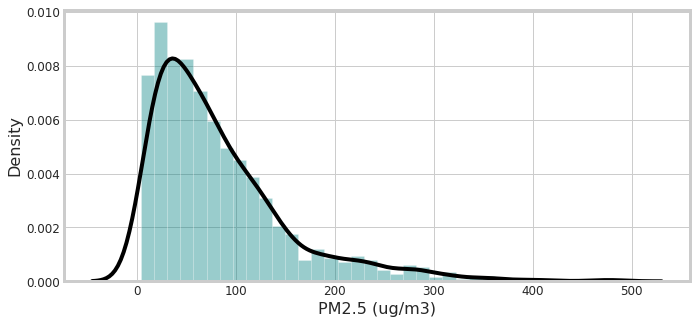

In [ ]:
# Density Plot and Histogram of all PM2.5 emissions
sns.set_style("whitegrid")  # Setting style(Optional)
plt.figure(figsize = (10,5)) #Specify the size of figure we want(Optional)
sns.distplot(x = daily_avg["PM2.5"]  ,  bins = int(180/5) , kde = True , color = 'teal'\
             , kde_kws=dict(linewidth = 4 , color = 'black'))
plt.xlabel("PM2.5 (ug/m3)", fontsize = 16)
plt.ylabel("Density", fontsize = 16)
plt.show()

- The distribution is not Gaussian (normal distribution).
- The distribution is left shifted.
- Transformations might be useful prior to modelling.

## Box and Whisker Plots

Text(0, 0.5, 'PM2.5 (ug/m3)')

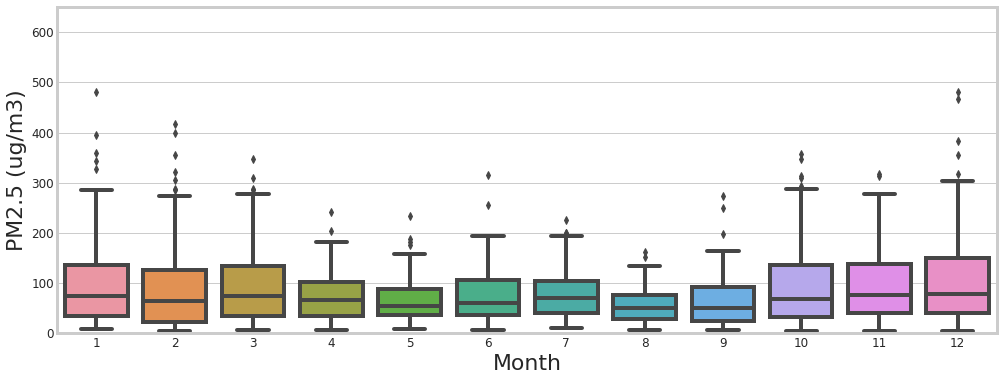

In [ ]:
# PM2.5 per month
fig, ax = plt.subplots(figsize=(15,6))
ax.set(ylim=(0,650))
sns.boxplot(data = daily_avg, x=daily_avg.index.month, y='PM2.5', ax=ax)
plt.xlabel("Month", fontsize = 22)
plt.ylabel("PM2.5 (ug/m3)", fontsize = 22)

## Extracting Time Features


We can split up the date-timestamp column into its different components. This will allow us to find patterns for different groups.

In [ ]:
# see: https://www.kaggle.com/robikscube/starter-hourly-energy-consumption
daily_avg['dow'] = daily_avg.index.dayofweek
daily_avg['doy'] = daily_avg.index.dayofyear
daily_avg['year'] = daily_avg.index.year
daily_avg['month'] = daily_avg.index.month
daily_avg['quarter'] = daily_avg.index.quarter
daily_avg['weekday'] = daily_avg.index.day_name()
daily_avg['woy'] = daily_avg.index.weekofyear
daily_avg['dom'] = daily_avg.index.day # Day of Month
daily_avg['date'] = daily_avg.index.date 

# let's add the season number
daily_avg['season'] = daily_avg['month'].apply(lambda month_number: (month_number%12 + 3)//3)

## Plotting PM2.5 over time

In [ ]:
# plotly doesn't allow us to access the index, so let's copy it into a column 
daily_avg['date_and_time'] = daily_avg.index

# plotting
fig = px.line(daily_avg,
              x='date_and_time',
              y='PM2.5',
              title=f'Levels of 24-Hour Average PM2.5 [{min(daily_avg.year)} - {max(daily_avg.year)}]',
              template="none")
fig.update_traces(line=dict(width=1))
fig.update_layout(xaxis_title='Date (yyyy/mm/dd)',
                  yaxis_title='PM2.5 (ug/m3)')
fig.show()

In [ ]:
# plotly doesn't allow us to access the index, so let's copy it into a column 
daily_avg['date_and_time'] = daily_avg.index

# plotting
fig = px.line(daily_avg,
              x='date_and_time',
              y='PM2.5',
              title=f'Levels of 24-Hour Average PM2.5 [{min(daily_avg.year)} - {max(daily_avg.year)}]',
              template="plotly_white")
fig.update_traces(line=dict(width=1))
fig.update_layout(xaxis_title='Date (yyyy/mm/dd)',
                  yaxis_title='PM2.5 (ug/m3)')
fig.show()

# Decomposing Time-Series

Trend - Consistent upwards or downwards slope of a time series

Seasonal - Clear periodic pattern of a time series(like sine funtion)

Noise - Outliers or missing values

In [ ]:
# seasonal_decompose needs a dataframe with a datetime index
series = daily_avg[['PM2.5']]
frequency = 365

# decomposing the time-series, with the frequency being 24 hours per 365 days
decomposed = seasonal_decompose(series, model='additive', freq=frequency)
decomposed.observed['date_and_time'] = decomposed.observed.index
decomposed.trend['date_and_time'] = decomposed.trend.index
decomposed.seasonal['date_and_time'] = decomposed.seasonal.index
decomposed.resid['date_and_time'] = decomposed.resid.index

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=4, cols=1,
    subplot_titles=("Observed", "Trend", "Seasonality", "Residuals"))

# Add traces
fig.add_trace(go.Scatter(x=decomposed.observed['date_and_time'], y=decomposed.observed['PM2.5'],
                         line=dict(width=1.5)), row=1, col=1)
fig.add_trace(go.Scatter(x=decomposed.trend['date_and_time'], y=decomposed.trend['PM2.5'], 
                         line=dict(width=2)), row=2, col=1)
fig.add_trace(go.Scatter(x=decomposed.seasonal['date_and_time'], y=decomposed.seasonal['PM2.5'],
                         line=dict(width=1.5)), row=3, col=1)
fig.add_trace(go.Scatter(x=decomposed.resid['date_and_time'], y=decomposed.resid['PM2.5'],
                         line=dict(width=1.5)), row=4, col=1)

# Update xaxis properties
fig.update_xaxes(title_text="Year", row=1, col=1, showticklabels=True)
fig.update_xaxes(title_text="Year", row=2, col=1)
fig.update_xaxes(title_text="Year", row=3, col=1)
fig.update_xaxes(title_text="Year", row=4, col=1)

# Update yaxis properties
fig.update_yaxes(title_text="PM2.5 (ug/m3)", row=1, col=1)
fig.update_yaxes(title_text="PM2.5 (ug/m3)", row=2, col=1)
fig.update_yaxes(title_text="PM2.5 (ug/m3)", row=3, col=1)
fig.update_yaxes(title_text="PM2.5 (ug/m3)", row=4, col=1)

fig.update_layout(height=800, width=900,
                  title_text="Time Series Decomposition",
                  template="plotly_white",
                  showlegend=False)

fig.show()

In [ ]:
# plotting the different elements constituting our time-series
def plot_decompositions(decompositions, titles, line_widths):
    for d, t, lw in zip(decompositions, titles, line_widths):
        
        # draw a line plot of the data
        fig = px.line(d,
              x='date_and_time',
              y='PM2.5',
              title=t,
              height=300,
              template="plotly_white")
        
        # adjust line width
        fig.update_traces(line=dict(width=lw))
        
        # change layout of axes and the figure's margins 
        # to emulate tight_layout
        fig.update_layout(
            xaxis=dict(title='Date (yyyy/mm/dd)',
                showticklabels=True,
                linewidth=1
            ),
            yaxis=dict(title='PM2.5 (ug/m3)'),
            margin=go.layout.Margin(
                l=40, r=40, b=0, t=40, pad=0
            ),
        )

        # display
        fig.show()

# calling the function 
plot_decompositions(decompositions=[decomposed.trend, 
                                    decomposed.seasonal, 
                                    decomposed.resid],
                    titles=[ 'Trend', 
                            'Seasonality',
                            'Residuals'],
                    line_widths=[2, 1, 1])

- There is clearly an downward trend in the above plot.
- You can also see the uniform seasonal change.
- Non-uniform noise that represent outliers and missing values

# Date & Time Patterns

### Yearly Seasonal Patterns

Season 1 = Winter

Season 2 = Spring

Season 3 = Summer

Season 4 = Fall

In [ ]:
# aggregated data
_ = daily_avg\
    .groupby(['year', 'season'], as_index=False)\
    .agg({'PM2.5':'mean'})

# plotting
fig = px.line(_, 
              x='year', 
              y='PM2.5', 
              color='season',
              template="plotly_white")
fig.update_layout(xaxis_title='Year',
                  yaxis_title='PM2.5 (ug/m3)',
                  font_size=17)
fig.show()

PM2.5 is highest during the winters

### Yearly Quarterly Patterns

First quarter, Q1: 1 January – 31 March
Second quarter, Q2: 1 April – 30 June
Third quarter, Q3: 1 July – 30 September
Fourth quarter, Q4: 1 October – 31 December

In [ ]:
# aggregated data
_ = daily_avg\
    .groupby(['year', 'quarter'], as_index=False)\
    .agg({'PM2.5':'mean'})

# plotting
fig = px.line(_, 
              x='year', 
              y='PM2.5', 
              color='quarter', 
              template="plotly_white")
fig.update_layout(xaxis_title='Year',
                  yaxis_title='PM2.5 (ug/m3)',
                  font_size=17)
fig.show()

# Test Stationarity

A Time Series is said to be stationary if its statistical properties such as mean, variance remain constant over time.

## Rolling Statistics

We can plot the moving average or moving variance and see if it varies with time. Moving average/variance is for any instant ‘t’, the average/variance of the last year, i.e. last 12 months.

In [ ]:
#Determing rolling statistics
def TestStationaryStats(ts):
    rol_mean = ts.rolling(window = 30, center = False).mean()
    rol_std = ts.rolling(window = 30, center = False).std()
    
    plt.plot(ts, color = 'black',label = 'Original Data', linewidth=2)
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='orange', label = 'Rolling Std')
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    
    plt.xlabel('Date (yyyy/mm)', fontsize = 13)
    plt.ylabel('PM2.5 (ug/m3)', fontsize = 13)
    plt.legend(loc='best', fontsize = 12)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 14)
    plt.show(block= True)

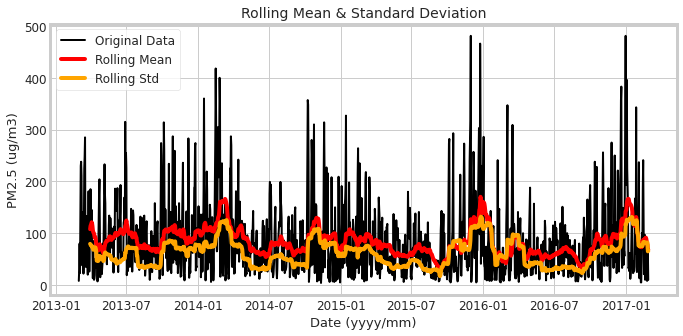

In [ ]:
plt.figure(figsize = (10,5))
TestStationaryStats(daily_avg['PM2.5'])

## ACF and PACF plots
Let's review the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots: 
- If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.
- This data is non-stationary as a high number of previous observations are correlated with future values.
- Confidence intervals are drawn as a cone.
- By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.
- The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

Autocorrelation - The autocorrelation function (ACF) measures how a series is correlated with itself at different lags.

Partial Autocorrelation - The partial autocorrelation function can be interpreted as a regression of the series against its past lags. The terms can be interpreted the same way as a standard linear regression, that is the contribution of a change in that particular lag while holding others constant.

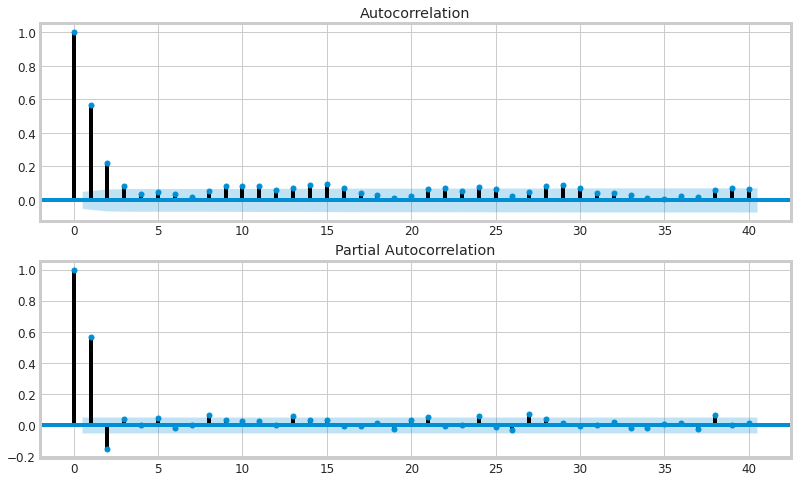

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(daily_avg["PM2.5"].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(daily_avg["PM2.5"].iloc[13:], lags=40, ax=ax2)

## Augmented Dickey-Fuller Test

This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

For a Time series to be stationary, its ADCF test should have:

1. p-value to be low (according to the null hypothesis)
2. The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics

In [ ]:
#Perform Augmented Dickey–Fuller test:
def TestStationaryAdfuller(ts):
    print('Results of Dickey Fuller Test:')
    
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)

In [ ]:
TestStationaryAdfuller(daily_avg["PM2.5"])

Results of Dickey Fuller Test:
Test Statistic                -1.110032e+01
p-value                        3.879981e-20
#Lags Used                     7.000000e+00
Number of Observations Used    1.453000e+03
Critical Value (1%)           -3.434859e+00
Critical Value (5%)           -2.863531e+00
Critical Value (10%)          -2.567830e+00
dtype: float64


From the above ADCF test result, we see that p-value is very low. However critical values are no where close to the Test Statistics. Hence, we can safely say that our Time Series at the moment is not stationary

## Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”)

KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

Null Hypothesis: The process is trend stationary.

Alternate Hypothesis: The series has a unit root (series is not stationary).

In [ ]:
# KPSS test:
def TestStationaryKPSS(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

In [ ]:
TestStationaryKPSS(daily_avg["PM2.5"])

KPSS Statistic: 0.43994569643049675
p-value: 0.05993719981444107
num lags: 24
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


# Remove Seasonality and Trend 

Making Series Stationary

There are 2 major reasons behind non-stationaruty of a TS:

- Trend – varying mean over time. In this case we saw that on average, PM2.5 emissions was decreasing over time. 
- Seasonality – variations at specific time-frames. In this case, PM2.5 emission greatly increase during the winter seasons

## Regular Differencing

- In this technique, we take the difference of the observation at a particular instant with that at the previous instant.
- First order differencing in Pandas

In [ ]:
ts_first_diff = daily_avg["PM2.5"] - daily_avg["PM2.5"].shift(1)

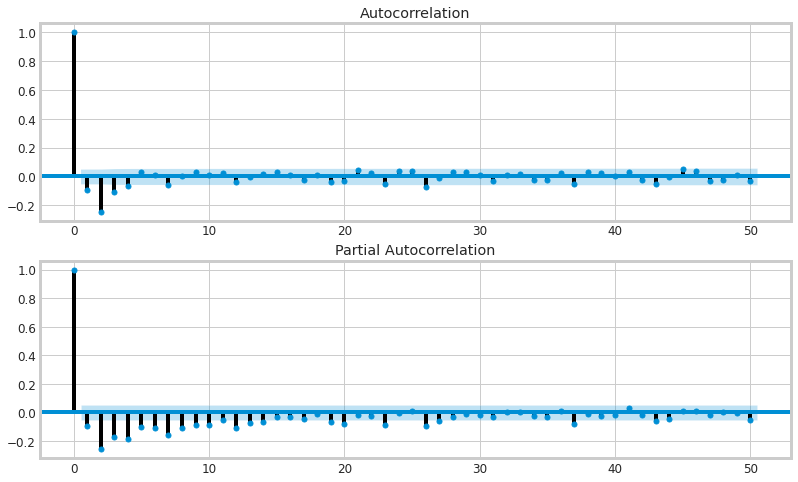

In [ ]:
ts_first_diff.dropna(inplace=True)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_first_diff.iloc[13:], lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_first_diff.iloc[13:], lags=50, ax=ax2)

In [ ]:
#Determing rolling statistics
def TestStationaryStats(ts):
    rol_mean = ts.rolling(window = 30, center = False).mean()
    rol_std = ts.rolling(window = 30, center = False).std()
    
    plt.plot(ts, color = 'black',label = 'Original Data', linewidth=3)
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='orange', label = 'Rolling Std')
    # plt.xticks(fontsize = 12)
    # plt.yticks(fontsize = 12)
    
    plt.xlabel('Date (yyyy/mm)', fontsize = 14)
    plt.ylabel('PM2.5 (ug/m3)', fontsize = 14)
    plt.legend(loc='best', fontsize = 12)
    plt.title('First Differenced Rolling Statistics', fontsize = 15)
    plt.show(block= True)

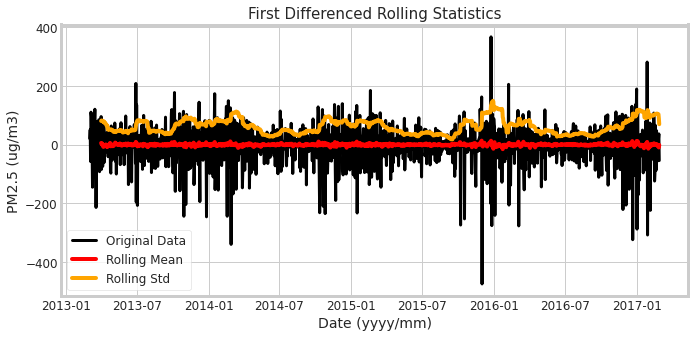

Results of Dickey Fuller Test:
Test Statistic                -1.342726e+01
p-value                        4.078854e-25
#Lags Used                     2.200000e+01
Number of Observations Used    1.437000e+03
Critical Value (1%)           -3.434909e+00
Critical Value (5%)           -2.863553e+00
Critical Value (10%)          -2.567842e+00
dtype: float64


In [ ]:
plt.figure(figsize = (10,5))
TestStationaryStats(ts_first_diff)
TestStationaryAdfuller(ts_first_diff)

In [ ]:
TestStationaryKPSS(ts_first_diff)

KPSS Statistic: 0.018937691253986404
p-value: 0.1
num lags: 24
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



## Seasonal Differencing


In [ ]:
# The seasonal difference
ts_seasonal_diff = daily_avg["PM2.5"] - daily_avg["PM2.5"].shift(365)
ts_seasonal_diff.dropna(inplace=True)

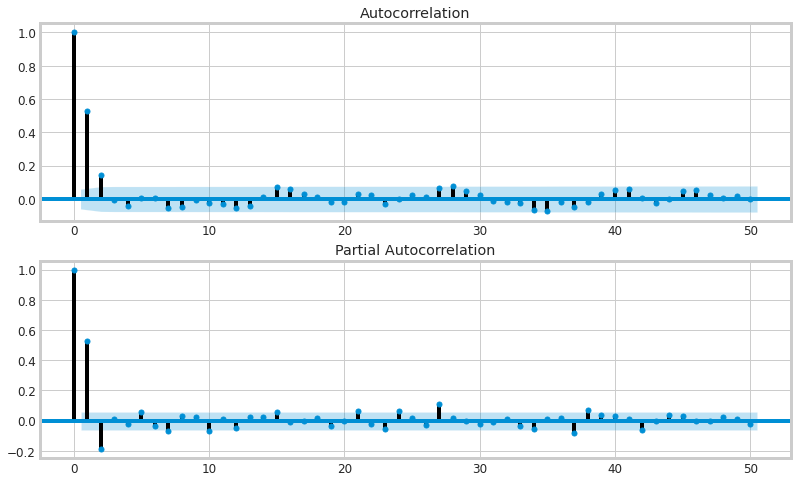

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_seasonal_diff.iloc[13:], lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_seasonal_diff.iloc[13:], lags=50, ax=ax2)

In [ ]:
#Determing rolling statistics
def TestStationaryStats(ts):
    rol_mean = ts.rolling(window = 30, center = False).mean()
    rol_std = ts.rolling(window = 30, center = False).std()
    
    plt.plot(ts, color = 'black',label = 'Original Data', linewidth=3)
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='orange', label = 'Rolling Std')
    # plt.xticks(fontsize = 12)
    # plt.yticks(fontsize = 12)
    
    plt.xlabel('Date (yyyy/mm)', fontsize = 14)
    plt.ylabel('PM2.5 (ug/m3)', fontsize = 14)
    plt.legend(loc='best', fontsize = 12)
    plt.title('Seasonal Differenced Rolling Statistics', fontsize = 15)
    plt.show(block= True)

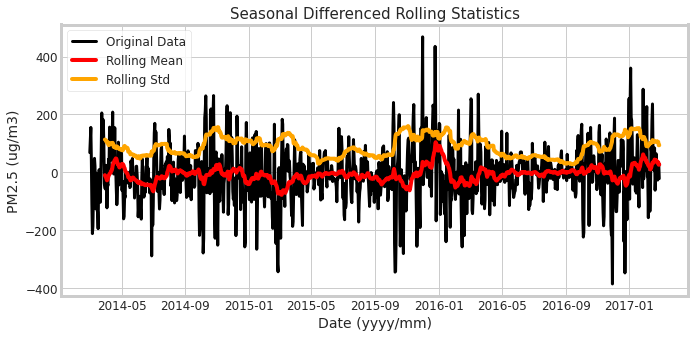

Results of Dickey Fuller Test:
Test Statistic                -1.056472e+01
p-value                        7.568775e-19
#Lags Used                     9.000000e+00
Number of Observations Used    1.086000e+03
Critical Value (1%)           -3.436386e+00
Critical Value (5%)           -2.864205e+00
Critical Value (10%)          -2.568189e+00
dtype: float64


In [ ]:
plt.figure(figsize = (10,5))
TestStationaryStats(ts_seasonal_diff)
TestStationaryAdfuller(ts_seasonal_diff)

In [ ]:
TestStationaryKPSS(ts_seasonal_diff)

KPSS Statistic: 0.35002589779223514
p-value: 0.09869573371024347
num lags: 22
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


# Prophet Time Series 

- Prophet is open source software released by Facebook's Core Data Science team.
- Prophet is a procedure for forecasting time series data based on an additive/multiplicative model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.
- It works best with time series that have strong seasonal effects and several seasons of historical data.
- Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.
- The Prophet package provides intuitive parameters which are easy to tune.

## Training Data

Train = all observations

In [ ]:
daily_avg_copy.count()

PM2.5            1461
dow              1461
doy              1461
year             1461
month            1461
quarter          1461
weekday          1461
woy              1461
dom              1461
date             1461
season           1461
date_and_time    1461
dtype: int64

In [ ]:
# format data for prophet model using 'ds' and 'y'
train_prophet = daily_avg_copy\
                    .reset_index()\
                    .rename(columns={
                        'index':'ds', 
                        'PM2.5':'y'
                    })

## Original Data Forecasting

In [ ]:
# linear trend
# 95% CI
# CN=China
# add quarterly seasonality
prophet = Prophet(growth='linear', yearly_seasonality=True, interval_width=0.95, seasonality_mode="additive")
prophet.add_country_holidays(country_name='CN')
prophet.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')

prophet.fit(train_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
forecast = prophet.predict(train_prophet)

In [ ]:
# to see what Chinese holidays were included
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Chinese New Year,Chinese New Year_lower,Chinese New Year_upper,Dragon Boat Festival,Dragon Boat Festival_lower,Dragon Boat Festival_upper,Labor Day,Labor Day_lower,Labor Day_upper,Mid-Autumn Festival,Mid-Autumn Festival_lower,Mid-Autumn Festival_upper,National Day,National Day_lower,National Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,Tomb-Sweeping Day,Tomb-Sweeping Day_lower,Tomb-Sweeping Day_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,quarterly,quarterly_lower,quarterly_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-03-01,101.430935,3.261427,258.765052,101.430935,101.430935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.279048,31.279048,31.279048,0.0,0.0,0.0,-167.368737,-167.368737,-167.368737,3.090570,3.090570,3.090570,195.557215,195.557215,195.557215,0.0,0.0,0.0,132.709983
1,2013-03-02,101.401236,10.747011,264.387718,101.401236,101.401236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.190692,38.190692,38.190692,0.0,0.0,0.0,-187.856697,-187.856697,-187.856697,7.587245,7.587245,7.587245,218.460144,218.460144,218.460144,0.0,0.0,0.0,139.591929
2,2013-03-03,101.371538,16.072070,256.093525,101.371538,101.371538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.857454,32.857454,32.857454,0.0,0.0,0.0,-207.209384,-207.209384,-207.209384,0.763328,0.763328,0.763328,239.303510,239.303510,239.303510,0.0,0.0,0.0,134.228992
3,2013-03-04,101.341840,-2.803039,257.995985,101.341840,101.341840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.980962,25.980962,25.980962,0.0,0.0,0.0,-225.686482,-225.686482,-225.686482,-6.083220,-6.083220,-6.083220,257.750664,257.750664,257.750664,0.0,0.0,0.0,127.322802
4,2013-03-05,101.312141,15.618314,254.925103,101.312141,101.312141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.964626,27.964626,27.964626,0.0,0.0,0.0,-243.218444,-243.218444,-243.218444,-2.316491,-2.316491,-2.316491,273.499561,273.499561,273.499561,0.0,0.0,0.0,129.276767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2017-02-24,74.547140,-43.134409,196.264298,74.547140,74.547140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.418466,0.418466,0.418466,0.0,0.0,0.0,-66.211087,-66.211087,-66.211087,3.090570,3.090570,3.090570,63.538983,63.538983,63.538983,0.0,0.0,0.0,74.965605
1457,2017-02-25,74.545775,-45.602492,211.339345,74.545775,74.545775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.761834,3.761834,3.761834,0.0,0.0,0.0,-94.760345,-94.760345,-94.760345,7.587245,7.587245,7.587245,90.934934,90.934934,90.934934,0.0,0.0,0.0,78.307609
1458,2017-02-26,74.544410,-50.099046,204.920174,74.544410,74.544410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.159090,-2.159090,-2.159090,0.0,0.0,0.0,-121.165713,-121.165713,-121.165713,0.763328,0.763328,0.763328,118.243295,118.243295,118.243295,0.0,0.0,0.0,72.385320
1459,2017-02-27,74.543046,-56.572144,203.360532,74.543046,74.543046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.317859,-6.317859,-6.317859,0.0,0.0,0.0,-145.289255,-145.289255,-145.289255,-6.083220,-6.083220,-6.083220,145.054616,145.054616,145.054616,0.0,0.0,0.0,68.225187


Text(17.475, 0.5, 'PM2.5 (ug/m3)')

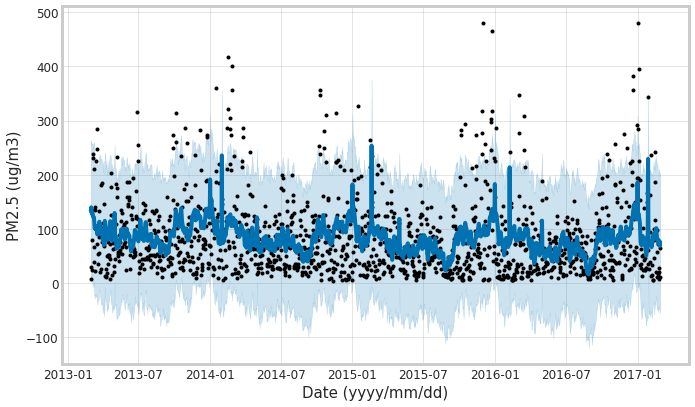

In [ ]:
#fig = prophet.plot(forecast, xlabel= 'Date (yyyy/mm/dd)', ylabel='PM2.5 (ug/m3)')
figsize=(20, 12)
fig = prophet.plot(forecast, xlabel='Date', ylabel='Value')
ax = fig.gca()
# ax.set_title("Forecast of 24-Hour PM2.5 Average [2013 - 2020]", size=20)
ax.set_xlabel("Date (yyyy/mm/dd)", size=15)
ax.set_ylabel("PM2.5 (ug/m3)", size=15)

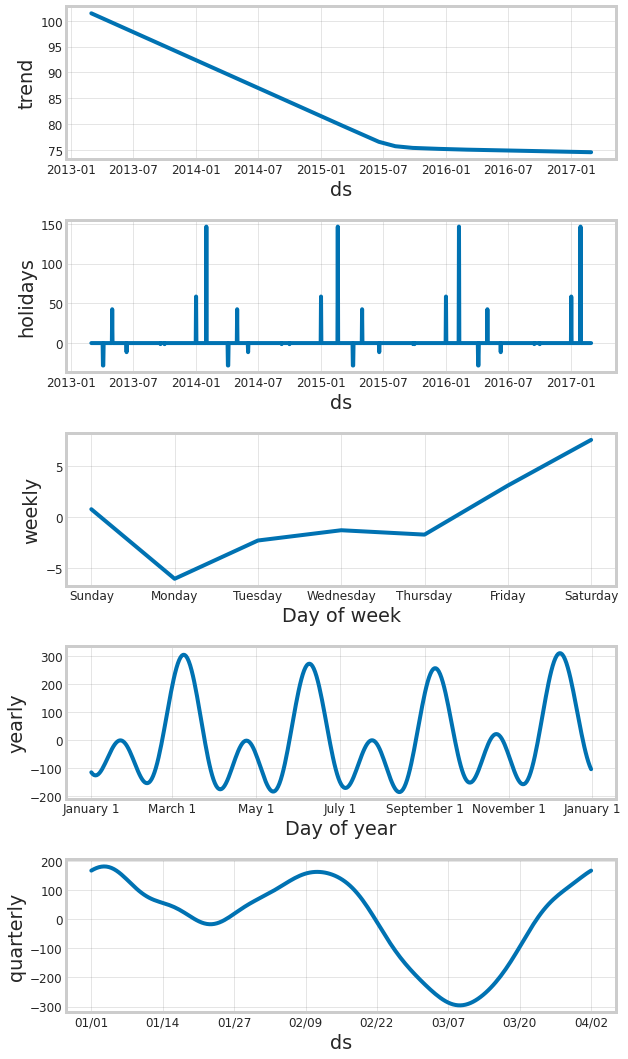

In [ ]:
fig1 = prophet.plot_components(forecast)

In [ ]:
# Prophet AIC

from math import log
# calculate aic for regression
def calculate_aic(n, mse, num_params):
    aic = n * log(mse) + 2 * num_params
    return aic

# number of parameters
num_params = 5
print('Number of parameters: %d' % (num_params))
# predict the training set
yhat = forecast["yhat"]
y = train_prophet["y"]
# calculate the error
mse = mean_squared_error(y, yhat)
print('MSE: %.3f' % mse)
# calculate the aic
aic = calculate_aic(len(y), mse, num_params)
print('AIC: %.3f' % aic)

Number of parameters: 5
MSE: 4350.589
AIC: 12250.355


### Error Metrics

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [ ]:
evaluate_forecast(y=train_prophet['y'],
                   pred=forecast['yhat'])

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.128144,48.897233,38.447852,4350.589269,0.774369,136.186937,65.958997


### Cross Validation

In [ ]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-03-07,105.200091,-27.357726,226.873976,218.0,2015-03-06
1,2015-03-08,93.061767,-33.345455,225.640577,126.0,2015-03-06
2,2015-03-09,79.756019,-41.805329,199.928576,9.0,2015-03-06
3,2015-03-10,74.090287,-54.513083,198.074633,34.0,2015-03-06
4,2015-03-11,69.053102,-52.550541,194.299318,43.0,2015-03-06
...,...,...,...,...,...,...
360,2016-03-01,70.373760,-53.087311,199.343286,118.0,2015-03-06
361,2016-03-02,70.832513,-56.910859,194.680282,160.0,2015-03-06
362,2016-03-03,82.963340,-41.133952,215.559043,277.0,2015-03-06
363,2016-03-04,90.842761,-30.977320,210.292059,347.0,2015-03-06


INFO:fbprophet:Making 3 forecasts with cutoffs between 2015-03-06 00:00:00 and 2016-02-29 00:00:00


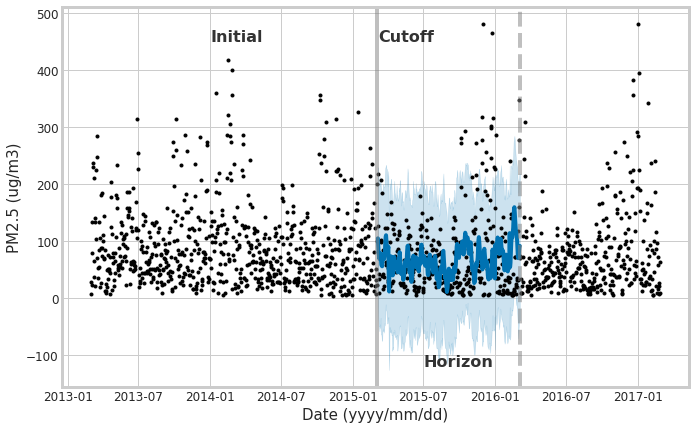

In [ ]:
df_cv =  cross_validation(prophet, initial='730 days', period='180 days', horizon = '365 days')
cutoff = df_cv['cutoff'].unique()[0]
df_cv = df_cv[df_cv['cutoff'].values == cutoff]

fig = plt.figure(facecolor='w', figsize=(10, 7))
ax = fig.add_subplot(111)
ax.plot(prophet.history['ds'].values, prophet.history['y'], 'k.')
ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)
ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
# ax.set_title("Cutoff of 24-Hour PM2.5 Average [2015 - 2016]", size=15)
ax.set_xlabel("Date (yyyy/mm/dd)", size=15)
ax.set_ylabel("PM2.5 (ug/m3)", size=15)
ax.text(x=pd.to_datetime('2014-01-01'),y=450, s='Initial', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
ax.text(x=pd.to_datetime('2015-03-07'),y=450, s='Cutoff', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('365 days'), c='gray', lw=4,
           alpha=0.5, ls='--')
ax.text(x=pd.to_datetime('2015-07-01'),y=-120, s='Horizon', color='black',
       fontsize=16, fontweight='bold', alpha=0.8);

In [ ]:
cutoff

numpy.datetime64('2015-03-06T00:00:00.000000000')

In [ ]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
360,2016-03-01,70.373760,-70.002483,185.313750,118.0,2015-03-06
361,2016-03-02,70.832513,-51.014465,203.411921,160.0,2015-03-06
362,2016-03-03,82.963340,-41.127524,211.902277,277.0,2015-03-06
363,2016-03-04,90.842761,-38.138273,219.368686,347.0,2015-03-06
364,2016-03-05,91.795785,-38.375699,218.086033,70.0,2015-03-06


In [ ]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days,3213.348379,56.686404,45.948103,0.981123,0.544414,0.972222
1,37 days,2907.380203,53.920128,43.963096,1.055082,0.574347,0.972222
2,38 days,2883.456584,53.697827,43.463584,1.063207,0.574347,0.972222
3,39 days,2753.251805,52.471438,41.994299,0.853379,0.562659,0.972222
4,40 days,2889.477216,53.753858,43.122150,0.838998,0.562659,0.972222


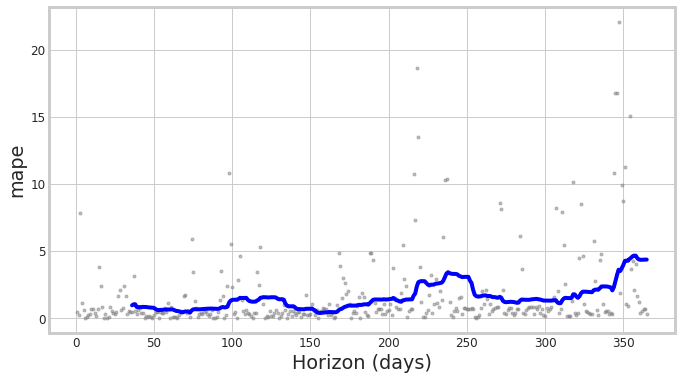

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

### Residuals Analysis

In [ ]:
# combine forcaset and train
# total_df = pd.concat([forecast.reset_index()['ds'],forecast['yhat'],train_prophet['y'][:1154]],axis=1)

In [ ]:
residuals = train_prophet['y'] - forecast['yhat']
fitted = forecast['yhat']

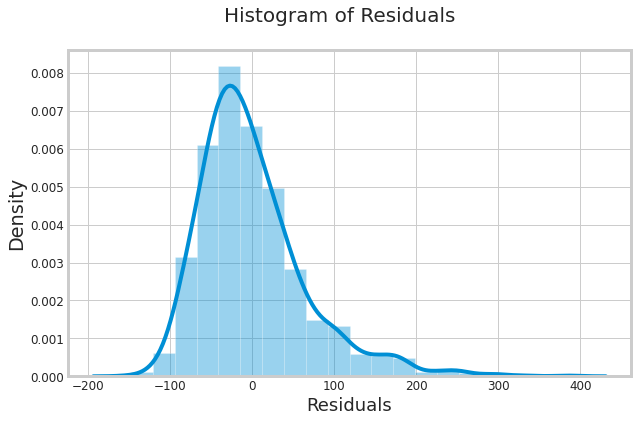

In [ ]:
fig = plt.figure(figsize=(9,6))
sns.distplot(residuals, bins = 20)
fig.suptitle('Histogram of Residuals', fontsize = 20)                  # Plot heading 
plt.xlabel('Residuals', fontsize = 18)
plt.show()

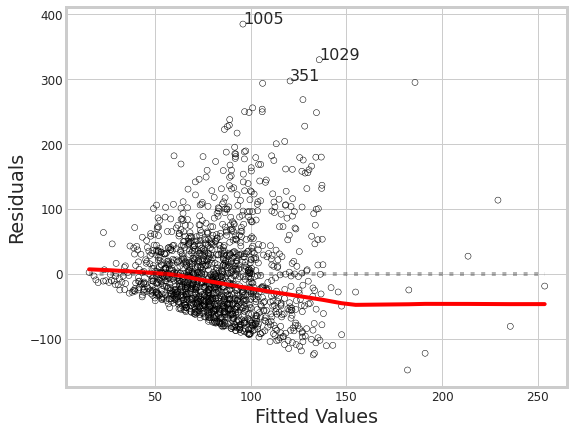

In [ ]:
lowess = sm.nonparametric.lowess
smoothed = lowess(residuals,fitted)
top3 = abs(residuals).sort_values(ascending = False)[:3]

plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (8,7)
fig, ax = plt.subplots()
ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
# ax.set_title('Residuals vs. Fitted')
ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

for i in top3.index:
    ax.annotate(i,xy=(fitted[i],residuals[i]))

plt.show()

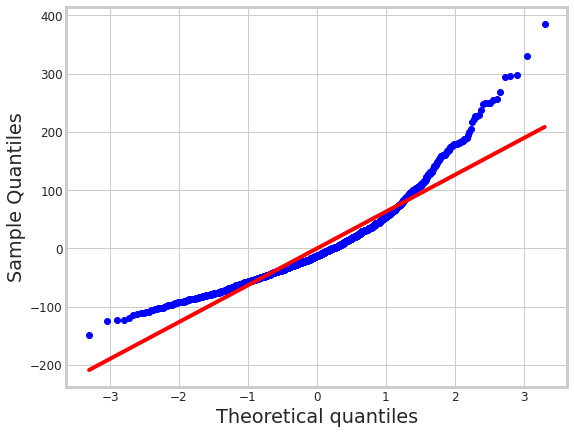

In [ ]:
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("")
plt.ylabel("Sample Quantiles")
plt.show()

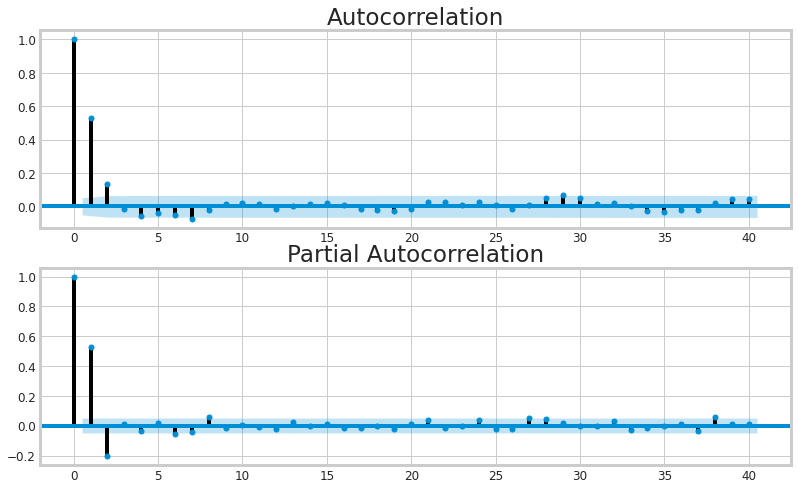

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals.iloc[13:], lags=40, ax=ax2)

## Future Forecasting

In [ ]:
# three year forecast
future = prophet.make_future_dataframe(periods=365*3, freq='D')
print(future.head(2))
print(future.tail(2))

          ds
0 2013-03-01
1 2013-03-02
             ds
2554 2020-02-27
2555 2020-02-28


In [ ]:
forecast = prophet.predict(future)

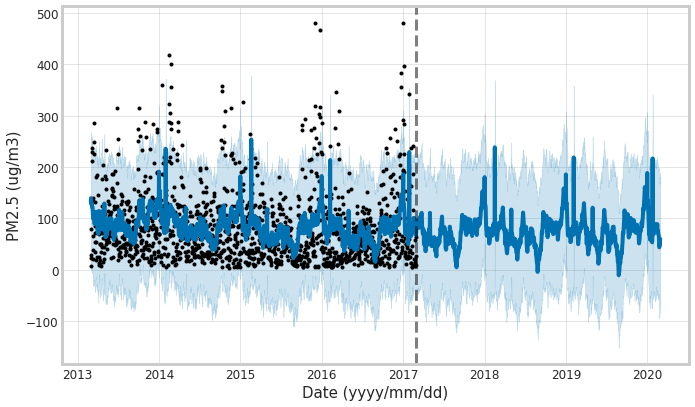

In [ ]:
#fig = prophet.plot(forecast, xlabel= 'Date (yyyy/mm/dd)', ylabel='PM2.5 (ug/m3)')
figsize=(20, 12)
fig = prophet.plot(forecast, xlabel='Date', ylabel='Value')
ax = fig.gca()
# ax.set_title("Forecast of 24-Hour PM2.5 Average [2013 - 2020]", size=20)
ax.set_xlabel("Date (yyyy/mm/dd)", size=15)
ax.set_ylabel("PM2.5 (ug/m3)", size=15)
ax.axvline(x=pd.to_datetime('2017-02-28'), c='black', lw=3,
           alpha=0.5, ls='--')

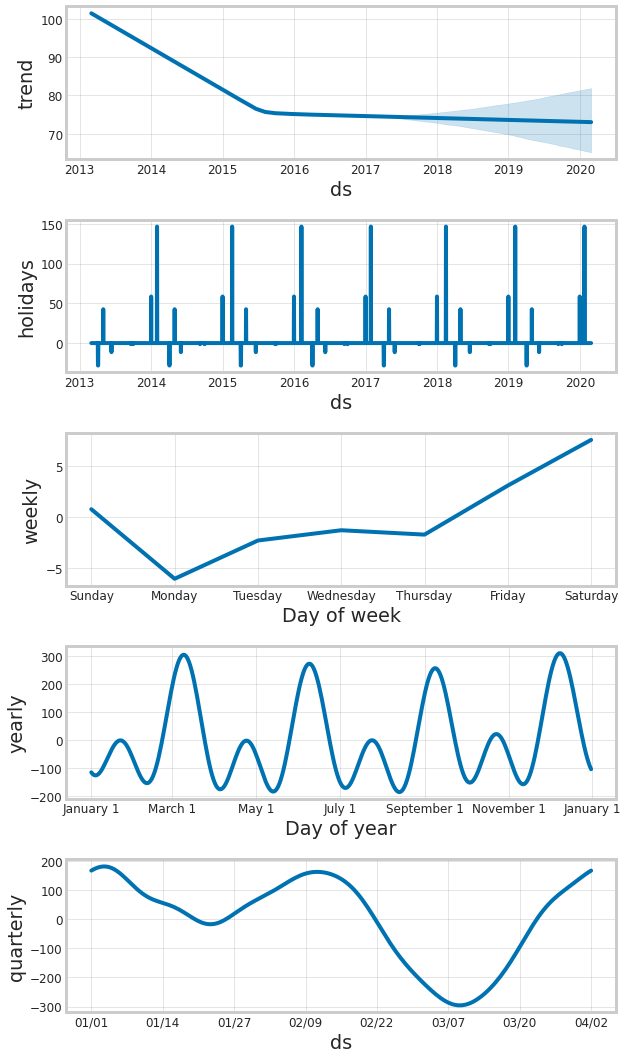

In [ ]:
fig1 = prophet.plot_components(forecast)

## Air Quality Index (AQI)

In [ ]:
# Revised Breakpoints (µg/m3, 24-hour average)
def AQI_Breakpoints(i):
    if i >= 0.0 and i <= 12:
        return 'Good'
    if i >= 12.1 and i <= 35.4:
        return 'Moderate'
    if i >= 35.5 and i <= 55.4:
        return 'Unhealthy for Sensitive Groups'
    if i >= 55.5 and i <= 150.4:
        return 'Unhealthy'
    if i >= 150.5 and i <= 250.4:
        return 'Very Unhealthy'
    if i >= 250.5 and i <= 500:
        return 'Hazardous'
    # if i >= 350.5 and i <= 500:
        # return 'Very Hazardous'

In [ ]:
daily_avg_copy['AQI'] = daily_avg_copy['PM2.5'].apply(AQI_Breakpoints)

In [ ]:
daily_avg["AQI"].value_counts()

Unhealthy                         627
Moderate                          320
Unhealthy for Sensitive Groups    235
Very Unhealthy                    138
Good                               86
Hazardous                          55
Name: AQI, dtype: int64

In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Chinese New Year,Chinese New Year_lower,Chinese New Year_upper,Dragon Boat Festival,Dragon Boat Festival_lower,Dragon Boat Festival_upper,Labor Day,Labor Day_lower,Labor Day_upper,Mid-Autumn Festival,Mid-Autumn Festival_lower,Mid-Autumn Festival_upper,National Day,National Day_lower,National Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,Tomb-Sweeping Day,Tomb-Sweeping Day_lower,Tomb-Sweeping Day_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,quarterly,quarterly_lower,quarterly_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-03-01,101.430935,-1.846655,259.102240,101.430935,101.430935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.279048,31.279048,31.279048,0.0,0.0,0.0,-167.368737,-167.368737,-167.368737,3.090570,3.090570,3.090570,195.557215,195.557215,195.557215,0.0,0.0,0.0,132.709983
1,2013-03-02,101.401236,20.717367,268.279360,101.401236,101.401236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.190692,38.190692,38.190692,0.0,0.0,0.0,-187.856697,-187.856697,-187.856697,7.587245,7.587245,7.587245,218.460144,218.460144,218.460144,0.0,0.0,0.0,139.591929
2,2013-03-03,101.371538,-0.021355,260.249012,101.371538,101.371538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.857454,32.857454,32.857454,0.0,0.0,0.0,-207.209384,-207.209384,-207.209384,0.763328,0.763328,0.763328,239.303510,239.303510,239.303510,0.0,0.0,0.0,134.228992
3,2013-03-04,101.341840,1.859204,258.331791,101.341840,101.341840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.980962,25.980962,25.980962,0.0,0.0,0.0,-225.686482,-225.686482,-225.686482,-6.083220,-6.083220,-6.083220,257.750664,257.750664,257.750664,0.0,0.0,0.0,127.322802
4,2013-03-05,101.312141,4.940053,243.558139,101.312141,101.312141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.964626,27.964626,27.964626,0.0,0.0,0.0,-243.218444,-243.218444,-243.218444,-2.316491,-2.316491,-2.316491,273.499561,273.499561,273.499561,0.0,0.0,0.0,129.276767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2551,2020-02-24,73.052853,-94.243740,181.917580,65.252397,81.864006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-29.117128,-29.117128,-29.117128,0.0,0.0,0.0,-66.211087,-66.211087,-66.211087,-6.083220,-6.083220,-6.083220,43.177179,43.177179,43.177179,0.0,0.0,0.0,43.935725
2552,2020-02-25,73.051488,-92.553471,167.457822,65.241751,81.876850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-26.702855,-26.702855,-26.702855,0.0,0.0,0.0,-94.760345,-94.760345,-94.760345,-2.316491,-2.316491,-2.316491,70.373982,70.373982,70.373982,0.0,0.0,0.0,46.348633
2553,2020-02-26,73.050123,-83.301373,180.500419,65.227791,81.889694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-24.685446,-24.685446,-24.685446,0.0,0.0,0.0,-121.165713,-121.165713,-121.165713,-1.305902,-1.305902,-1.305902,97.786168,97.786168,97.786168,0.0,0.0,0.0,48.364677
2554,2020-02-27,73.048759,-82.754911,181.209833,65.213443,81.902537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-22.016020,-22.016020,-22.016020,0.0,0.0,0.0,-145.289255,-145.289255,-145.289255,-1.735530,-1.735530,-1.735530,125.008765,125.008765,125.008765,0.0,0.0,0.0,51.032738


In [ ]:
low_forecast_df = forecast[['ds', 'yhat_lower']]
forecast_df = forecast[['ds', 'yhat']]
upp_forecast_df = forecast[['ds', 'yhat_upper']]

low_forecast_df['AQI'] = low_forecast_df['yhat_lower'].apply(AQI_Breakpoints)
forecast_df['AQI'] = forecast_df['yhat'].apply(AQI_Breakpoints)
upp_forecast_df['AQI'] = upp_forecast_df['yhat_upper'].apply(AQI_Breakpoints)

In [ ]:
low_aqi_forecast = low_forecast_df[0:1461].dropna()
aqi_forecast = forecast_df[0:1461].dropna()
upp_aqi_forecast = upp_forecast_df[0:1461].dropna()

In [ ]:
aqi_forecast = forecast_df[0:1461].dropna()
aqi_future = forecast_df[1461:2555].dropna()

In [ ]:
aqi_forecast["AQI"].value_counts()

Unhealthy                         1283
Unhealthy for Sensitive Groups     142
Moderate                            26
Very Unhealthy                       8
Hazardous                            1
Name: AQI, dtype: int64

In [ ]:
aqi_future["AQI"].value_counts()

Unhealthy                         806
Unhealthy for Sensitive Groups    188
Moderate                           67
Very Unhealthy                     15
Good                                9
Name: AQI, dtype: int64

In [ ]:
# AQI of og data
# ordered for legend order

order_daily_avg = daily_avg.sort_values(by='PM2.5', ascending=True)

fig = px.scatter(order_daily_avg, 
              x='date_and_time', 
              y='PM2.5', 
              color='AQI', 
              color_discrete_map={
                "Good": "#16FF32",
                "Moderate": "yellow",
                "Unhealthy for Sensitive Groups": "orange",
                "Unhealthy": "red",
                "Very Unhealthy": "darkred",
                "Hazardous": "black"},
              # title='Yearly 24-Hour PM2.5 Average per Season',
              template="plotly_white")
fig.update_layout(xaxis_title='Year',
                  yaxis_title='PM2.5',
                  font_size=17)
fig.update_layout(legend={'traceorder':'normal'})
fig.show()

In [ ]:
# combined forecast for yhat, yhat_lower, and yhat_upper
# ordered yhats for correcrt legend order
order_aqi_forecast = aqi_forecast.sort_values(by='yhat', ascending=True)
order_low_aqi_forecast = low_aqi_forecast.sort_values(by='yhat_lower', ascending=True)
order_upp_aqi_forecast = upp_aqi_forecast.sort_values(by='yhat_upper', ascending=True)

fig2 = px.scatter(order_aqi_forecast, 
              x='ds', 
              y='yhat', 
              color='AQI',
              color_discrete_map={
                "Good": "#16FF32",
                "Moderate": "yellow",
                "Unhealthy for Sensitive Groups": "orange",
                "Unhealthy": "red",
                "Very Unhealthy": "darkred",
                "Hazardous": "black"},
              title='Max Yearly 24-Hour PM2.5 Average per Season')

fig1 = px.scatter(order_low_aqi_forecast, 
              x='ds', 
              y='yhat_lower', 
              color='AQI',
              color_discrete_map={
                "Good": "#16FF32",
                "Moderate": "yellow",
                "Unhealthy for Sensitive Groups": "orange",
                "Unhealthy": "red",
                "Very Unhealthy": "darkred",
                "Hazardous": "black"})

fig3 = px.scatter(order_upp_aqi_forecast, 
              x='ds', 
              y='yhat_upper', 
              color='AQI',
              color_discrete_map={
                "Good": "#16FF32",
                "Moderate": "yellow",
                "Unhealthy for Sensitive Groups": "orange",
                "Unhealthy": "red",
                "Very Unhealthy": "darkred",
                "Hazardous": "black"})

fig4 = go.Figure(data=fig1.data + fig2.data + fig3.data)

names=set()

fig4.for_each_trace(
    lambda trace:
        trace.update(showlegend=False)
        if (trace.name in names) else names.add(trace.name))

fig4.update_layout(xaxis_title='Year',
                  yaxis_title='PM2.5')
#fig1.show()
# fig2.show()
# fig3.show()
fig4.show()

In [ ]:
# combine forecast and future model values

# order PM2.5 for correct legend order
order_aqi_future = aqi_future.sort_values(by='yhat', ascending=True)
order_aqi_forecast = aqi_forecast.sort_values(by='yhat', ascending=True)

fig1 = px.scatter(order_aqi_future, 
              x='ds', 
              y='yhat', 
              color='AQI',
              color_discrete_map={
                "Good": "#16FF32",
                "Moderate": "yellow",
                "Unhealthy for Sensitive Groups": "orange",
                "Unhealthy": "red",
                "Very Unhealthy": "darkred",
                "Hazardous": "black"})
fig1.update_layout(showlegend=False)

fig2 = px.scatter(order_aqi_forecast, 
              x='ds', 
              y='yhat', 
              color='AQI',
              color_discrete_map={
                "Good": "#16FF32",
                "Moderate": "yellow",
                "Unhealthy for Sensitive Groups": "orange",
                "Unhealthy": "red",
                "Very Unhealthy": "darkred",
                "Hazardous": "black"})
fig2.update_layout(showlegend=False)

In [ ]:
fig3 = go.Figure(data=fig1.data + fig2.data)

fig3.update_layout(xaxis_title='Year',
                  yaxis_title='PM2.5',
                  legend={'traceorder':'normal'},
                  template="plotly_white",
                   font_size=17)

# no dublicate legend names
names=set()

fig3.for_each_trace(
    lambda trace:
        trace.update(showlegend=False)
        if (trace.name in names) else names.add(trace.name))

# add vertical line to distingusih between past and future
fig3.add_shape(type="line",
    x0='2017-02-28', y0=0, x1='2017-02-28', y1=300,
    line=dict(color="black",width=2, dash="dash"))

fig3.show()